# 객체 탐지 문제 (Object detection)

객체 탐지 문제란 입력 이미지 속에 있는 객체의 위치를 찾고 그 객체가 무엇인지 분류하는 것을 말한다.

특히 이미지 데이터를 사용하기 때문에 이미지에 강한 신경망 구조인 CNN 모델이 주로 사용되어 진다.


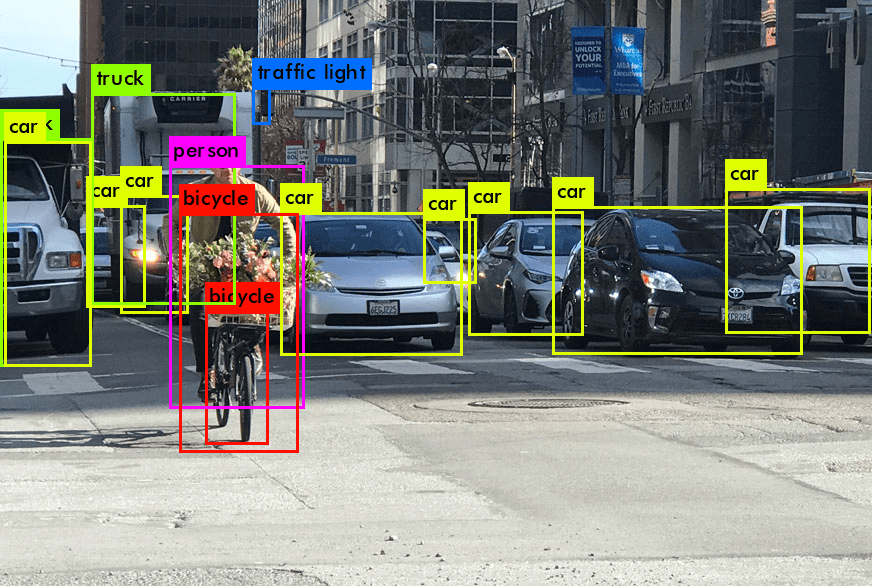

# 1.객체 탐지 문제의 주요 요소

객체 탐지 문제는 이미지 내에서 두가지 정보를 한번에 얻어내야 한다.

바로 "객체 분류"와 "객체 위치" 이다.

- 분류 : 검출한 객체가 무엇인지 예측하는 것. => classification
- 객체 위치 : 이미지 내에서 객체의 영역 (bounding box) 을 찾는 것. => regression

즉, 모델 하나로 두가지 문제를 해결해야 함.

## 2. 객체 탐지 문제의 기본적인 구조

1. 2-stage architecture : 객체 분류 신경망과 객체 위치 신경망을 따로 두어 구성하는 것. (ex. R-CNN, 먼저 이미지로부터 객체의 위치를 탐지 후 해당 위치의 객체가 무엇인지 예측)

2. 1-stage architecture : 하나의 신경망 구조로부터 객체 분류와 객체 위치를 모두 예측해 내는 것 (ex. YOLO, CNN 기반의 모델의 출력으로 객체 분류 라벨, bounding box, confidence 모두를 gride 단위로 예측)

# 3. 객체 탐지를 위한 CNN 모델 구조 설계

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleObjectDetector(nn.Module):
    """
    1-stage CNN-based object detector
    """
    def __init__(self, num_classes=80, input_size=224):
        super(SimpleObjectDetector, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        # 이미지 feature extraction layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Adaptive pooling
            nn.AdaptiveAvgPool2d((7, 7))
        )

        # 7x7크기로 얻은 출력값에 대해 FC 활용을 위해 1차원 벡터 형태로 변경
        self.feature_size = 512 * 7 * 7

        # bounding box regression 파트
        self.bbox_head = nn.Sequential(
            nn.Linear(self.feature_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 4),
            nn.Sigmoid()
        )

        # Enhanced classification head 파트
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # 특징 추출
        features = self.features(x)
        features = features.view(features.size(0), -1)

        # 예측값 얻기
        bbox_preds = self.bbox_head(features)
        class_preds = self.classifier(features)

        return bbox_preds, class_preds

# 4. 객체 탐지를 위한 데이터셋 전처리 코드

In [14]:
from torch.utils.data import Dataset, DataLoader
import cv2

from torchvision import transforms, datasets
import torchvision.transforms.v2 as v2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from pycocotools.coco import COCO
import xml.etree.ElementTree as ET


class VocDatasetWrapper(Dataset):
    """
    물체 인식을 위한 Pascal VOC dataset
    """
    def __init__(self, root, year='2012', image_set='train', transform=None, input_size=224):
        self.voc_dataset = datasets.VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.transform = transform
        self.input_size = input_size

        # VOC 데이터셋 클래스 이름 종류
        self.class_names = [
            'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
            'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
            'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
        ]

    def __len__(self):
        return len(self.voc_dataset)

    def __getitem__(self, idx):
        image, target = self.voc_dataset[idx]

        # PIL image 형식을 numpy array 형식으로 변경 (cv2 사용을 위해)
        image = np.array(image)
        if len(image.shape) == 2:  # 이미지가 흑백인 경우 RGB 이미지로 변경
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # 이미지 크기 추출
        h, w = image.shape[:2]

        # XML annotation, 타겟 분류 및 bbox 불러오기
        bbox_normalized, class_label = self._parse_voc_annotation(target, w, h)

        # 이미지 크기 균일화
        image = cv2.resize(image, (self.input_size, self.input_size))

        # 이미지 데이터 증강 과정
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, torch.tensor(bbox_normalized, dtype=torch.float32), torch.tensor(class_label, dtype=torch.long)

    def _parse_voc_annotation(self, target, w, h):
        """Parse VOC XML annotation"""
        annotation = target['annotation']

        if 'object' in annotation:
            # 이미지 오브젝트 불러오기 (이미지 정보가 담김)
            obj = annotation['object']
            if isinstance(obj, list):
                obj = obj[0]

            # 바운딩 박스 정보 추출 및 정규화
            bbox = obj['bndbox']
            x_min = float(bbox['xmin']) / w
            y_min = float(bbox['ymin']) / h
            x_max = float(bbox['xmax']) / w
            y_max = float(bbox['ymax']) / h

            # x_min: 왼쪽 가로, y_min: 아래 세로, x_max: 오른쪽 가로, y_max: 위 세로
            bbox_normalized = [x_min, y_min, x_max, y_max]

            # 클래스 정보 추출
            class_name = obj['name']
            class_label = self.class_names.index(class_name) if class_name in self.class_names else 0
        else:
            # 이미지 오브젝트 없는 경우 처리
            bbox_normalized = [0, 0, 1, 1]
            class_label = 0

        return bbox_normalized, class_label


# 데이터 증강 과정 정의
def create_data_transforms(input_size=224):
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((input_size, input_size)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet 데이터셋 통계값
    ])

    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet 데이터셋 통계값
    ])

    return train_transform, val_transform

## 5. 객체 탐지 학습 과정 설계

In [15]:
# 하이퍼 파라미터
learning_rate = 1e-3
num_classes = 20
batch_size = 16
num_epochs = 10

# Create transforms
train_transform, val_transform = create_data_transforms(input_size=224)

#  Using Pascal VOC Dataset 불러오기
print("Loading Pascal VOC dataset...")
voc_train = VocDatasetWrapper(
    root='./data/VOC',
    year='2012',
    image_set='train',
    transform=train_transform,
    input_size=224
)

voc_val = VocDatasetWrapper(
    root='./data/VOC',
    year='2012',
    image_set='val',
    transform=val_transform,
    input_size=224
)


# 데이터 로더 설정하기
train_loader = DataLoader(voc_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(voc_val, batch_size=batch_size, shuffle=False, num_workers=2)

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleObjectDetector(num_classes=20, input_size=224).to(device)

# 손실함수 설정하기
bbox_loss_fn = nn.SmoothL1Loss()
class_loss_fn = nn.CrossEntropyLoss()
objectness_loss_fn = nn.BCELoss()

# 옵티마이져 설정과 학습률 스케줄러 추가
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# 학습 기록을 위한 리스트
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    # 학습 시작
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (images, bboxes, labels) in enumerate(train_loader):
        images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)

        # 순방향 계산
        bbox_preds, class_preds = model(images)

        # 손실 함수 계산하기
        # 바운드 박스 손실 값
        bbox_loss = bbox_loss_fn(bbox_preds, bboxes)
        # 클레스 분류 손실 값
        class_loss = class_loss_fn(class_preds, labels)
        # 최종 손실 값 계산
        total_loss = bbox_loss + class_loss

        # 역전파 계산
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()

        # 정확도 계산
        _, predicted = torch.max(class_preds.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 모델 검증 시작
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, bboxes, labels in val_loader:
            images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)

            bbox_preds, class_preds = model(images)

            bbox_loss = bbox_loss_fn(bbox_preds, bboxes)
            class_loss = class_loss_fn(class_preds, labels)
            objectness_targets = (labels > 0).float().unsqueeze(1)

            total_loss = bbox_loss + class_loss
            val_loss += total_loss.item()

            _, predicted = torch.max(class_preds.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # 평가 지표 계산하기
    avg_train_loss = train_loss / len(train_loader) # train loss
    avg_val_loss = val_loss / len(val_loader) # valid loss
    train_acc = 100 * train_correct / train_total # train accuracy
    val_acc = 100 * val_correct / val_total # valid accuracy

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # 모델 상태 출력
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
    print('-' * 60)

    # 학습률 변경
    scheduler.step()

Loading Pascal VOC dataset...
Epoch [1/10]
Train Loss: 3.1720, Train Acc: 13.26%
Val Loss: 2.8141, Val Acc: 17.96%
LR: 0.001000
------------------------------------------------------------
Epoch [2/10]
Train Loss: 2.8493, Train Acc: 14.76%
Val Loss: 2.7540, Val Acc: 18.80%
LR: 0.001000
------------------------------------------------------------
Epoch [3/10]
Train Loss: 2.8158, Train Acc: 15.34%
Val Loss: 2.7526, Val Acc: 17.50%
LR: 0.001000
------------------------------------------------------------
Epoch [4/10]
Train Loss: 2.8000, Train Acc: 16.81%
Val Loss: 2.7765, Val Acc: 16.90%
LR: 0.001000
------------------------------------------------------------
Epoch [5/10]
Train Loss: 2.7604, Train Acc: 16.49%
Val Loss: 2.9016, Val Acc: 12.11%
LR: 0.001000
------------------------------------------------------------
Epoch [6/10]
Train Loss: 2.7754, Train Acc: 16.74%
Val Loss: 2.7964, Val Acc: 17.48%
LR: 0.001000
------------------------------------------------------------
Epoch [7/10]
Tra

## 6.학습된 모델로부터 바운딩 박스 결과 확인하기

[131, 57, 191, 216]
[125, 72, 177, 224]
[21, 68, 185, 180]
[0, 32, 198, 214]
[121, 123, 131, 143]


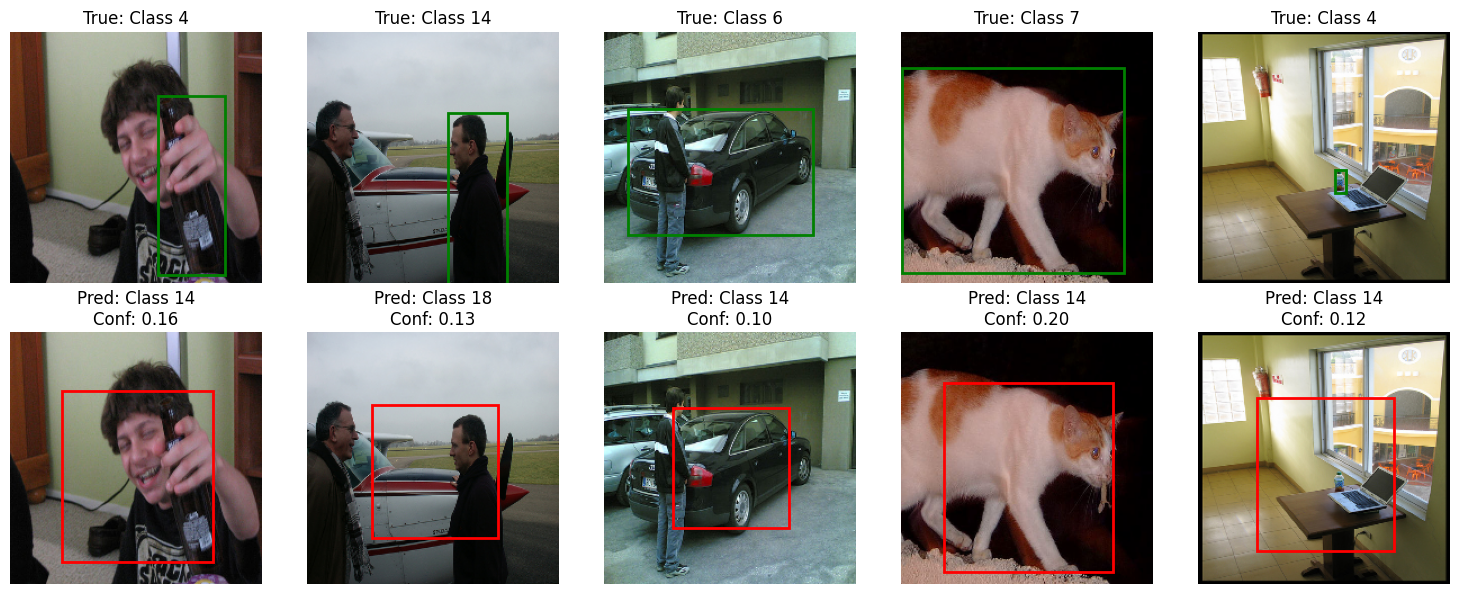

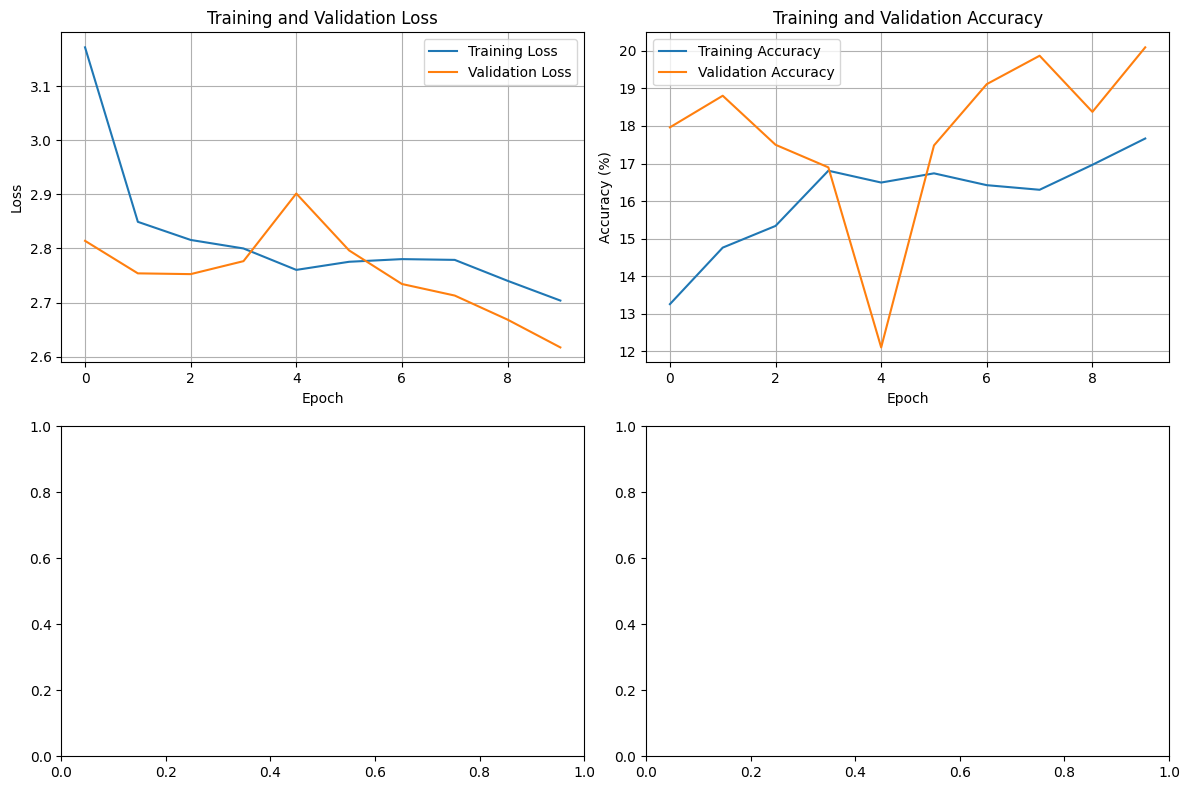

In [16]:
def visualize_predictions(model, dataset, device='cuda', num_samples=5):
    """
    학습된 모델로 부터 예측 결과 확인하기
    """
    model.eval()

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        # 임의의 예제 이미지 선택
        idx = np.random.randint(0, len(dataset))
        image, bbox_true, label_true = dataset[idx]

        image_tensor = image.unsqueeze(0).to(device)

        # 예측값 얻기
        with torch.no_grad():
            bbox_pred, class_pred = model(image_tensor)

            bbox_pred = bbox_pred[0].cpu().numpy() # 예측 bbox
            class_pred = torch.softmax(class_pred[0], dim=0) # 예측 분포
            predicted_class = torch.argmax(class_pred).item() # 예측 클래스
            confidence = class_pred[predicted_class].item() # 예측 클래스의 확률

        # 정규화된 이미지를 원래 이미지로 복구
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # ImageNet 데이터셋 통계값, 정규화 반대 과정
        image_np = np.clip(image_np, 0, 1) # 0~1 사이 값으로 클립핑

        # 좌표 재정렬
        # bbox의 출력은 이미지 크기에 대해 0~1로 정규화된 값
        h, w = image_np.shape[:2]

        # True bbox
        bbox_true_img = [
            int(bbox_true[0] * w), int(bbox_true[1] * h),
            int(bbox_true[2] * w), int(bbox_true[3] * h)
        ]

        # Predicted bbox
        bbox_pred_img = [
            int(bbox_pred[0] * w), int(bbox_pred[1] * h),
            int(bbox_pred[2] * w), int(bbox_pred[3] * h)
        ]

        print(bbox_true_img)

        # Plot original with true bbox
        axes[0, i].imshow(image_np)
        axes[0, i].add_patch(plt.Rectangle(
            (bbox_true_img[0], bbox_true_img[1]),
            bbox_true_img[2] - bbox_true_img[0],
            bbox_true_img[3] - bbox_true_img[1],
            fill=False, edgecolor='green', linewidth=2
        ))
        axes[0, i].set_title(f'True: Class {label_true}')
        axes[0, i].axis('off')

        # Plot prediction
        axes[1, i].imshow(image_np)
        axes[1, i].add_patch(plt.Rectangle(
            (bbox_pred_img[0], bbox_pred_img[1]),
            bbox_pred_img[2] - bbox_pred_img[0],
            bbox_pred_img[3] - bbox_pred_img[1],
            fill=False, edgecolor='red', linewidth=2
        ))
        axes[1, i].set_title(f'Pred: Class {predicted_class}\nConf: {confidence:.2f}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


# # Save model
# torch.save(model.state_dict(), 'object_detector_voc.pth')
# print("Model saved!")

# Visualize results
visualize_predictions(model, voc_val, device=device, num_samples=5)

# Plot training curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Training Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()